In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
APPLIANCES_ORDER[1:]

['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def modify_axes_for_sc(t_all):
    t_all_copy = t_all.copy()
    t_all_copy = t_all_copy.swapaxes(0, 2)
    return t_all_copy

In [8]:
t_all_copy = modify_axes_for_sc(t_all)
t_all_copy.shape

(336, 7, 52)

In [9]:
def train_test_sc(t_all):
    return t_all[:, :, :30], t_all[ :, :,30:]



In [10]:
# Creating dataset for MTF
tensor_mtf = tensor[valid_homes, :, 180:194, :]
tensor_mtf[30:, 1:, :, :] = np.nan

In [11]:
train_sc, test_sc = train_test_sc(t_all_copy)


In [12]:
class SparseCoding:
    def train(self, Xs, num_latent=2):
        """
        Xs: N appliance X T_time X M homes 
        N does not include the aggregate
        num_latent: number of latent factors
        """
        self.N, self.T, self.M = Xs.shape
        self.num_latent = num_latent
        from sklearn.decomposition import NMF
        self.As = []
        self.Bs = []
        for i in range(self.N):
            self.model = NMF(n_components=self.num_latent, init='random', random_state=0)
            self.Bs.append(self.model.fit_transform(Xs[i]))
            self.As.append(self.model.components_)
    
    def disaggregate_home(self, X_test_agg):
        from scipy.optimize import nnls
        
        As_learnt = nnls(np.hstack(self.Bs), X_test_agg)[0]
        As_per_appliance = As_learnt.reshape(self.N, self.num_latent)
        out = []
        for appliance_num in range(self.N):
            out.append(self.Bs[appliance_num]@As_per_appliance[appliance_num])
        return np.array(out)
    
    def disaggregate(self, X_test):
        """
        X_test: T_time X M homes containing aggregate data for M homes
        
        """
        self.pred = np.zeros((self.N, self.T, X_test.shape[1]))
        from scipy.optimize import nnls
        num_homes = X_test.shape[1]
        for home in range(num_homes):
            As_learnt = nnls(np.hstack(self.Bs), X_test[:,home])[0]
            As_per_appliance = As_learnt.reshape(self.N, self.num_latent)
            for appliance_num in range(self.N):
                self.pred[appliance_num, :, home] = self.Bs[appliance_num]@As_per_appliance[appliance_num]
        return self.pred
    
    def disaggregate_discriminative(self, X_train, X_test, num_iter=2, alpha=1e-5):
        from scipy.optimize import nnls
        self.prediction_iterations = np.zeros((num_iter, self.N, self.T, X_test.shape[1]))
        
        self.A_star = np.vstack(self.As)
        self.B_tilde = np.hstack(self.Bs)

        for iter_number in range(num_iter):
            print(iter_number)
            self.A_hat = nnls_autograd(self.B_tilde, X_train)
            self.B_tilde = self.B_tilde - alpha*((X_train-self.B_tilde@self.A_hat)@self.A_hat.T - ((X_train-self.B_tilde@self.A_star)@self.A_star.T))
            self.B_tilde[self.B_tilde<0.] = 0.
    
            num_homes = X_test.shape[1]
            for home in range(num_homes):
                As_learnt = nnls(self.B_tilde, X_test[:,home])[0]
                self.As_per_appliance = As_learnt.reshape(self.N, self.num_latent)
                
                for appliance_num in range(self.N):
                    self.prediction_iterations[iter_number, appliance_num, :, home] = self.B_tilde[:,appliance_num*self.num_latent:appliance_num*self.num_latent+self.num_latent]@self.As_per_appliance[appliance_num]
        return self.prediction_iterations
        

        

In [13]:
def nnls_autograd(A, B, num_iter=300, eps=1e-8, lr=4):
    """
    Ax = B
    """
    
    import autograd.numpy as np
    np.random.seed(0)
    from autograd import grad
    
    def cost(A, B, x):
        
        error = A@x - B
        return np.sqrt((error ** 2).mean())
    
    mg = grad(cost, argnum=2)
    
    M, N = B.shape
    r = A.shape[1]
    x = np.abs(np.random.randn(r, N))
  
    sum_x =  np.zeros_like(x)
    
    for i in range(num_iter):
        del_x = mg(A, B, x)
        sum_x += eps + np.square(del_x)
        lr_x = np.divide(lr, np.sqrt(sum_x))
        x -= lr_x * del_x
        
        x[x<0]=0.
        
        if i % 10 == 0:
            #print(cost(A, B, x), i)
            sys.stdout.flush()

    return x    
        
    

In [14]:
c = SparseCoding()
train_data = np.array([train_sc[:, i, :] for i in range(1, 7)])
c.train(train_data, num_latent=3)
p = c.disaggregate_discriminative(train_sc[:, 0, :], test_sc[:, 0, :], num_iter=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [15]:
p.shape

(100, 6, 336, 22)

In [16]:
gt_agg = test_sc[:, 0, :].T.copy()

In [17]:
pred_sc_0 = p[0].swapaxes(0,1).swapaxes(0, 2)

In [18]:
pred_sc = {}
for num_latent in range(1, 30, 2):
    print(num_latent)
    c = SparseCoding()
    train_data = np.array([train_sc[:, i, :] for i in range(1, 7)])
    c.train(train_data, num_latent=num_latent)
    pred_sc[num_latent] = c.disaggregate(test_sc[:, 0, :])
    pred_sc[num_latent] = pred_sc[num_latent].swapaxes(0,1).swapaxes(0, 2)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29


In [19]:
from tensor_custom_core import stf_3dim, stf_4dim_time

In [20]:
pred_mtf_all = {}
for r in range(1, 12):
    print(r)
    print("*"*20)
    H, A, D, T = stf_4dim_time(tensor_mtf, r=r, num_iter=400)
    pred_mtf_r = np.einsum("Hr, Ar, Dr, ATr ->HADT", H, A, D, T)[30:, 1:, :, :]
    pred_mtf_r = pred_mtf_r.reshape(22, 6, 14*24)
    pred_mtf_all[r] = pred_mtf_r



1
********************
1226.22349533 0
517.146378536 50
517.145906831 100
517.145903618 150
517.145903602 200
517.145903596 250
517.145903504 300
517.145901844 350
2
********************
1224.26735313 0
513.850893818 50
490.735842677 100
487.806357059 150
487.525878567 200
487.468998936 250
487.438667209 300
487.41457461 350
3
********************
1221.74921834 0
507.779510138 50
478.90536066 100
474.777275342 150
474.194765278 200
474.00887785 250
473.937706677 300
473.905821129 350
4
********************
1218.98795038 0
494.500748513 50
468.711210462 100
466.498499327 150
465.550736387 200
465.002340711 250
464.646538388 300
464.259732694 350
5
********************
1219.08391259 0
492.941283999 50
463.102394328 100
458.984573519 150
456.891689169 200
455.984805648 250
455.444524513 300
455.092753738 350
6
********************
1216.92420884 0
500.229194994 50
458.657319777 100
450.554694444 150
448.546892902 200
447.683190478 250
447.25645376 300
446.957304332 350
7
******************

In [21]:
gt = tensor[valid_homes, :, 180:194, :][30:, 1:, :, :].reshape(22, 6, 336)

In [22]:
mean_pred = np.zeros_like(pred_mtf_r)
mean_pred[:, :, :] = train_data.mean(axis=2)

In [ ]:
mean_absolute_error()

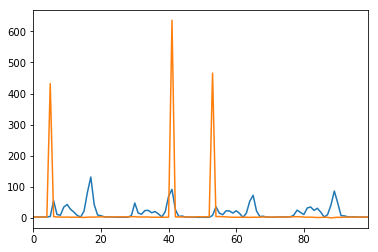

In [84]:
pd.DataFrame(pred_mtf_all[r][:,5,:]).iloc[0].head(100).plot()
pd.DataFrame(gt[:,5,:]).iloc[0].head(100).plot()

In [57]:
print(mean_absolute_error(pa.flatten(), pred_mtf_all[r][:,appliance_num,:].flatten()))
mean_absolute_error(pa, pred_mtf_all[r][:,appliance_num,:])

12.5210503654


12.521050365351025

In [23]:
err_mtf_all = {}


for r in range(1, 12):
    err_mtf_all[r] = {}
    for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
        pa = pred_mtf_all[r][:,appliance_num,:]
        pa[pa>gt_agg] = gt_agg[pa>gt_agg]
        #err_sc[appliance] = np.abs(pred_sc[appliance_num]-gt[appliance_num]).mean()
        err_mtf_all[r][appliance] = np.abs(pa-gt[:,appliance_num,:]).mean()


In [24]:
pd.DataFrame(err_mtf_all)

,1,2,3,4,5,6,7,8,9,10,11
dw,27.443441,27.736377,27.730207,27.725774,28.376556,28.547334,28.852048,29.512012,29.044897,29.521337,30.097115
fridge,37.640608,37.793890,36.601640,35.565967,36.987953,37.406032,37.143883,38.356988,37.299693,37.409178,41.756040
hvac,273.783189,271.332183,257.351809,257.275172,273.256861,263.257419,273.742277,247.367311,234.662925,248.362427,248.441096
mw,8.213624,8.228357,8.424444,8.363220,8.398282,8.469381,8.382217,8.781400,8.656094,8.477042,9.263400
oven,25.948707,26.304164,26.524509,27.343875,27.903536,27.879323,28.462925,28.376121,29.488139,28.294670,30.335691
wm,8.955449,8.986848,9.083706,9.020285,9.271590,9.206991,9.308554,9.651159,9.262288,9.453578,9.692287


In [25]:
err_sc = {}
#err_mtf = {}


for num_latent in range(1, 30, 2):
    err_sc[num_latent] = {}
    for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
        pa =pred_sc[num_latent][:,appliance_num,:]
        pa[pa>gt_agg] = gt_agg[pa>gt_agg]
        err_sc[num_latent][appliance] = np.abs(pa-gt[:,appliance_num,:]).mean()
    

In [26]:
test_sc.shape

(336, 7, 22)

In [27]:
pd.DataFrame(err_sc)

,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29
dw,24.717803,26.036747,28.165350,32.528055,34.363495,37.945024,41.298079,44.585082,45.379397,48.101456,49.280195,51.732736,52.760729,53.538945,54.454146
fridge,134.507206,113.173505,115.912251,101.198500,95.284314,101.954579,116.646439,115.147804,106.672735,102.640350,115.268210,119.559868,119.584093,112.565325,124.381766
hvac,287.178827,285.434883,302.293496,299.935715,299.130298,311.769722,336.639062,338.964115,336.785739,325.266763,342.618018,344.045308,364.408941,365.465602,372.553696
mw,12.981102,41.008369,47.810181,51.537599,58.274170,59.522554,67.931077,67.730592,68.949553,66.567800,69.096580,66.936881,69.272804,79.696525,73.321874
oven,21.452601,28.196417,27.461359,30.945929,32.638375,34.440496,38.059317,39.089263,41.008979,42.436250,41.146750,46.381052,60.703992,62.900322,56.236560
wm,14.514978,15.343153,18.353629,21.331893,23.188458,26.081055,30.296514,32.883461,37.865549,40.255842,39.709998,42.340535,44.835104,44.936366,48.587415


In [47]:
err_mean = {}
from sklearn.metrics import mean_absolute_error


for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    #err_sc[appliance] = np.abs(pred_sc[appliance_num]-gt[appliance_num]).mean()
    pa = mean_pred[:,appliance_num,:]
    pa[pa>gt_agg] = gt_agg[pa>gt_agg]
    err_mean[appliance] = mean_absolute_error(pa,gt[:,appliance_num,:])

In [30]:
err_sc_iteration = {}
for iteration_number in range(100):
    err_sc_iteration[iteration_number] = {}
    for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
        pa = p[iteration_number].swapaxes(0,1).swapaxes(0, 2)[:,appliance_num,:]
        pa[pa>gt_agg] = gt_agg[pa>gt_agg]
        err_sc_iteration[iteration_number][appliance] = np.abs(pa-gt[:,appliance_num,:]).mean()
        #err_mtf[appliance] = np.abs(pred_mtf[appliance_num]-gt[appliance_num]).mean()
    

In [31]:
pd.DataFrame(err_sc_iteration)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
dw,23.931508,22.590305,21.685865,21.230636,20.911229,20.715723,20.576939,20.525919,20.485877,20.456790,...,20.758611,20.770070,20.776833,20.788110,20.795000,20.806066,20.812729,20.823416,20.830467,20.841137
fridge,108.376497,105.833838,103.630388,102.072507,100.019528,97.840100,95.535033,93.576864,92.028752,90.849670,...,89.047083,89.562703,89.041147,89.552450,89.037093,89.545393,89.041717,89.537621,89.050904,89.528991
hvac,274.789266,268.739177,264.934432,262.648884,261.216226,260.356030,259.794567,259.392425,259.031769,259.036184,...,260.801576,260.813902,260.881935,260.901396,260.963610,260.991909,261.049013,261.079424,261.133307,261.165185
mw,36.877554,32.868437,32.439990,31.634828,31.965738,32.015765,32.546625,32.891541,33.419710,33.725823,...,40.056476,39.094123,40.097046,39.160727,40.139668,39.230837,40.184251,39.302830,40.227368,39.376042
oven,26.694591,25.889562,25.238343,24.754120,24.401840,24.108489,23.952609,23.861777,23.790544,23.739082,...,23.902426,23.951863,23.929024,23.977744,23.955870,24.003877,23.983251,24.030176,24.010416,24.056173
wm,14.145992,13.537787,13.055588,12.711629,12.452357,12.262293,12.131521,12.064819,12.044577,12.036191,...,17.755965,17.754926,17.828409,17.828810,17.902557,17.904504,17.977872,17.982325,18.054698,18.062174


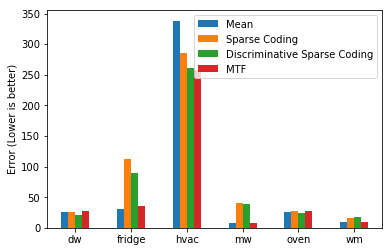

In [32]:
result_df = pd.DataFrame(
{"Mean":pd.Series(err_mean),
    "Sparse Coding":pd.DataFrame(err_sc)[3],
 "Discriminative Sparse Coding":pd.Series(err_sc_iteration[99]),
"MTF":pd.Series(err_mtf_all[4])})

result_df[['Mean','Sparse Coding','Discriminative Sparse Coding','MTF']].plot(kind='bar',rot=0)
plt.ylabel("Error (Lower is better)")

In [33]:
zero_pred = np.zeros_like(mean_pred)
err_zero ={}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    #err_sc[appliance] = np.abs(pred_sc[appliance_num]-gt[appliance_num]).mean()
    err_zero[appliance] = np.abs(zero_pred[:,appliance_num,:]-gt[:,appliance_num,:]).mean()
err_zero

{'dw': 14.499116173604689,
 'fridge': 88.953206155688036,
 'hvac': 937.65674098776663,
 'mw': 6.3002141955010273,
 'oven': 19.757201510373186,
 'wm': 5.6175211786375145}

In [34]:
result_df[['Mean','Sparse Coding','Discriminative Sparse Coding','MTF']].round(2)
result_df['Neural'] = pd.Series({'dw': 24.870927145657255,
 'fridge': 40.642622669315109,
 'hvac': 407.64503194612212,
 'mw': 9.5177636509070478,
 'oven': 24.630917072655215,
 'wm': 9.4858786798710284})

result_df['Neural-2'] = pd.Series({'dw': 29.358431969312235,
 'fridge': 46.049574236634484,
 'hvac': 283.006,
 'mw': 13.912724977296685,
 'oven': 31.718561047672001,
 'wm': 14.508136269518147})
result_df.round(2)

result_df['Neural-3'] = pd.Series({'dw': 23.464008758572668,
 'fridge': 39.864848516755472,
 'hvac': 533.6815996012117,
 'mw': 8.9078466720885121,
 'oven': 26.490912022011582,
 'wm': 8.9392344953567999})


result_df['Neural-4'] = pd.Series(
{'dw': 14.499260461576849,
 'fridge': 42.399899309367001,
 'hvac': 378.36,
 'mw': 6.1351733489069904,
 'oven': 19.079575800122715,
 'wm': 5.6176763162769507})

result_df['Neural-Recursive-GT-train-test-Clamping'] = pd.Series(
{'dw': 14.499561669749662,
 'fridge': 19.442246996062845,
 'hvac': 283.006,
 'mw': 4.9561252929779274,
 'oven': 17.788349601435847,
 'wm': 5.5211944597629605})

result_df['Neural-Recursive-Pred-train-test-Clamping'] = pd.Series(
{'dw': 14.499242038907688,
 'fridge': 57.896555920240864,
 'hvac': 283.00688944919409,
 'mw': 6.1927237581402199,
 'oven': 18.883580803837514,
 'wm': 5.6176462023111053})

result_df['Neural-Recursive-Pred-train-test-no-Clamping']=pd.Series({'dw': 14.49934903123088,
 'fridge': 38.578239118417287,
 'hvac': 378.0151754070539,
 'mw': 6.204401698959936,
 'oven': 18.528210689369651,
 'wm': 5.6177957878908371})

result_df['Neural-All-Appliances'] = pd.Series({'dw': 18.20616693073935,
 'fridge': 39.857332643076127,
 'hvac': 396.64220145165274,
 'mw': 8.4038905734016147,
 'oven': 21.31223434810008,
 'wm': 8.9579758694718219})

result_df['Neural-LSTM'] = pd.Series({'dw': 14.49,
 'fridge': 22.0286544907,
 'hvac': 203.94095046,
 'mw': 4.69,
 'oven': 17.6,
 'wm': 5.60})

result_df['ZeroEnergy'] = pd.Series(err_zero)

In [35]:
for appliance in result_df.index:
    result_df.loc[appliance,'DNN'] = np.min(np.array([result_df.loc[appliance,'Neural'], 
                                             result_df.loc[appliance,'Neural-2'],
                                            result_df.loc[appliance,'Neural-3'],
                                                               result_df.loc[appliance,'Neural-4']]))

In [36]:
result_df[['ZeroEnergy','Mean','Sparse Coding','Discriminative Sparse Coding',
           'MTF','DNN',
          'Neural-LSTM']].round(1)

,ZeroEnergy,Mean,Sparse Coding,Discriminative Sparse Coding,MTF,DNN,Neural-LSTM
dw,14.5,26.1,26.0,20.8,27.7,14.5,14.5
fridge,89.0,31.2,113.2,89.5,35.6,39.9,22.0
hvac,937.7,338.2,285.4,261.2,257.3,283.0,203.9
mw,6.3,8.2,41.0,39.4,8.4,6.1,4.7
oven,19.8,26.4,28.2,24.1,27.3,19.1,17.6
wm,5.6,9.1,15.3,18.1,9.0,5.6,5.6


In [37]:
def accuracy_pie_chart(ground_truth_appliance, prediction_appliance, gt_aggregate):
    out = 0.
    for i in range(6):
        out = out + min(np.sum(ground_truth_appliance[:, i, :]), np.sum(prediction_appliance[:, i, :]))
    return out/np.sum(gt_aggregate) +1e-8   

In [38]:
def hourly_4d(gt, pred_3d):
    """
    gt: (# homes, #appliances, #days * 24)
    """
    days = gt.shape[2]//24
    tensor = gt.reshape(gt.shape[0], gt.shape[1], days, 24)
    pred = pred_3d.reshape(gt.shape[0], gt.shape[1], days, 24)
    error = {}
    for appliance, appliance_name in enumerate(APPLIANCES_ORDER[1:]):
        error[appliance_name] = {}
        for home in range(gt.shape[0]):
            error[appliance_name][home] = 0.
            for hour in range(24):
                y_pred = pred[home, appliance, :, hour]
                y_true = tensor[home, appliance, :, hour]
                mask = ~np.isnan(y_true)
                if np.nansum(y_true) > 1:
                    error_hour = np.nansum((y_pred - y_true)[mask]) / np.nansum(y_true)

                    # error_hour =  np.nansum((y_pred - y_true)[mask])/max(np.nansum(y_true), np.nansum(y_pred))
                    error[appliance_name][home] += error_hour ** 2
            error[appliance_name][home] = np.sqrt(error[appliance_name][home])
    error = pd.DataFrame(error)
    error = error.replace(0.0, np.nan)
    return error

In [39]:

approach_pred = {'Mean':mean_pred, 'Sparse Coding':pred_sc[3], 
                 'Discriminative Sparse Coding':p[99].swapaxes(0,1).swapaxes(0,2),'MTF':pred_mtf_all[4],
                'Zero':zero_pred}

hourly_accuracies = {}
for approach_name, approach_prediction in approach_pred.items():
    hourly_accuracies[approach_name] = hourly_4d(gt, approach_prediction).median()

In [40]:
pd.DataFrame(hourly_accuracies)

,Discriminative Sparse Coding,MTF,Mean,Sparse Coding,Zero
dw,3.464102,13.454481,16.757141,8.803866,2.828427
fridge,4.527930,1.296900,0.932348,4.394509,4.898979
hvac,1.065059,1.226052,1.474746,1.174303,4.898979
mw,37.744721,8.226766,9.907931,26.901242,4.898979
oven,4.898979,15.154542,15.454602,13.812698,4.898979
wm,8.425723,6.091665,8.117330,8.918533,3.872983


In [41]:
approach_pred = {'Mean':mean_pred, 'Sparse Coding':pred_sc[3], 
                 'Discriminative Sparse Coding':p[99].swapaxes(0,1).swapaxes(0,2),'MTF':pred_mtf_all[4],
                'Zero':zero_pred}

pie_accuracies = {}
for approach_name, approach_prediction in approach_pred.items():
    pie_accuracies[approach_name] = accuracy_pie_chart(gt, approach_prediction, test_sc[:, 0, :])

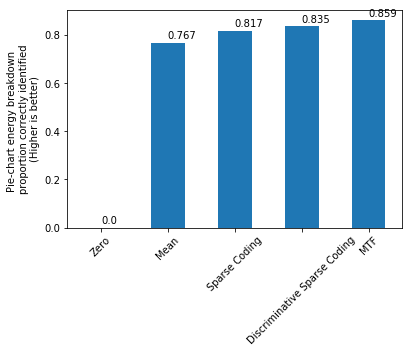

In [42]:
pie_accuracies = pd.Series(pie_accuracies).loc[['Zero','Mean','Sparse Coding','Discriminative Sparse Coding','MTF']]
ax = pie_accuracies.plot(kind='bar',rot=45)
for i, v in enumerate(pie_accuracies):
    ax.text( i,v+0.03, str(v.round(3)), va='center')
plt.ylabel("Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)")

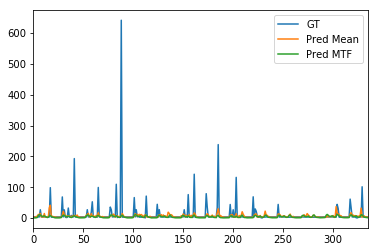

In [43]:
appliance="mw"
appliance_num = APPLIANCES_ORDER[1:].index(appliance)
ax = pd.DataFrame(gt[0:1, appliance_num, :]).T.squeeze().plot(label='GT')


pd.DataFrame(mean_pred[0:1, appliance_num, :]).T.squeeze().plot(ax=ax,label='Pred Mean' )
pd.DataFrame(pred_mtf_all[4][0:1, appliance_num, :]).T.squeeze().plot(ax=ax,label='Pred MTF' )


plt.legend()


In [44]:
err_mtf_all[4]

{'dw': 27.725773683912013,
 'fridge': 35.565966633648941,
 'hvac': 257.27517172697679,
 'mw': 8.3632201496899157,
 'oven': 27.343874637270154,
 'wm': 9.0202854906062822}

In [45]:
np.sum(gt[0:1, appliance_num, :]>10)

38